In [1]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pulp import *
import pandas as pd
import os, glob
import seaborn as sns
from scipy.stats import kruskal
import scikit_posthocs as sp
from scipy.stats import mannwhitneyu
from dotenv import load_dotenv

load_dotenv('./Credentials.env',override=True)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] =str(os.getenv("GOOGLE_APPLICATION_CREDENTIALS"))
os.environ['GCLOUD_PROJECT'] = str(os.getenv("GCLOUD_PROJECT"))

%load_ext google.cloud.bigquery
from google.cloud import bigquery
client=bigquery.Client()
from google.cloud import bigquery_storage_v1

In [3]:
%%bigquery Train_set_df
select * from `som-nero-phi-jonc101.blood_culture_stewardship.cohort` where order_year>=2015 and order_year<2022

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
%%bigquery Val_set_df
select * from `som-nero-phi-jonc101.blood_culture_stewardship.cohort` where order_year>=2022 and order_year<2023

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
%%bigquery Test_set_df
select * from `som-nero-phi-jonc101.blood_culture_stewardship.cohort` where order_year>=2023 

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
missing_percentage = Test_set_df.isnull().mean() * 100
missing_percentage[missing_percentage>80]

min_neutrophils             86.818038
max_neutrophils             86.818038
avg_neutrophils             86.818038
median_neutrophils          86.818038
min_lymphocytes             86.601230
max_lymphocytes             86.601230
avg_lymphocytes             86.601230
median_lymphocytes          86.601230
min_procalcitonin           91.520814
max_procalcitonin           91.520814
avg_procalcitonin           91.520814
median_procalcitonin        91.520814
bacteremia                  87.760170
infective_endocarditis      98.557237
septic_thrombophlebitis     99.428414
vascular_graft_infection    98.415326
CRBSI                       98.707032
infectious_discitis         99.802901
epidural_abscess            92.786187
septic_arthritis            98.545412
meningitis                  99.105172
meningitis_bacteria         99.854147
cholangitis                 97.780669
dtype: float64

In [7]:
Train_set_df['ed_arrival_datetime'] = pd.to_datetime(Train_set_df['ed_arrival_datetime'])
Train_set_df['blood_culture_order_datetime'] = pd.to_datetime(Train_set_df['blood_culture_order_datetime'])
Train_set_df['earliest_iv_antibiotic_datetime'] = pd.to_datetime(Train_set_df['earliest_iv_antibiotic_datetime'])

Val_set_df['ed_arrival_datetime'] = pd.to_datetime(Val_set_df['ed_arrival_datetime'])
Val_set_df['blood_culture_order_datetime'] = pd.to_datetime(Val_set_df['blood_culture_order_datetime'])
Val_set_df['earliest_iv_antibiotic_datetime'] = pd.to_datetime(Val_set_df['earliest_iv_antibiotic_datetime'])


Test_set_df['ed_arrival_datetime'] = pd.to_datetime(Test_set_df['ed_arrival_datetime'])
Test_set_df['blood_culture_order_datetime'] = pd.to_datetime(Test_set_df['blood_culture_order_datetime'])
Test_set_df['earliest_iv_antibiotic_datetime'] = pd.to_datetime(Test_set_df['earliest_iv_antibiotic_datetime'])


# Calculate the difference in hours:
Train_set_df['hours_between_ed_cult'] = (Train_set_df['blood_culture_order_datetime'] - Train_set_df['ed_arrival_datetime']).dt.total_seconds() / 3600
Test_set_df['hours_between_ed_cult'] = (Test_set_df['blood_culture_order_datetime'] - Test_set_df['ed_arrival_datetime']).dt.total_seconds() / 3600
Val_set_df['hours_between_ed_cult'] = (Val_set_df['blood_culture_order_datetime'] - Val_set_df['ed_arrival_datetime']).dt.total_seconds() / 3600


Train_set_df['hours_between_cult_abx'] = (Train_set_df['blood_culture_order_datetime'] - Train_set_df['earliest_iv_antibiotic_datetime']).dt.total_seconds() / 3600
Test_set_df['hours_between_cult_abx'] = (Test_set_df['blood_culture_order_datetime'] - Test_set_df['earliest_iv_antibiotic_datetime']).dt.total_seconds() / 3600
Val_set_df['hours_between_cult_abx'] = (Val_set_df['blood_culture_order_datetime'] - Val_set_df['earliest_iv_antibiotic_datetime']).dt.total_seconds() / 3600


In [8]:
Identifiers=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded']
Labels=['positive_blood_culture','positive_blood_culture_in_week']
Labs=['min_heartrate','max_heartrate', 'avg_heartrate', 'median_heartrate',
       'min_resprate', 'max_resprate', 'avg_resprate', 'median_resprate',
       'min_temp', 'max_temp', 'avg_temp', 'median_temp', 'min_sysbp',
       'max_sysbp', 'avg_sysbp', 'median_sysbp', 'min_diasbp',
       'max_diasbp', 'avg_diasbp', 'median_diasbp', 'min_wbc', 'max_wbc',
       'avg_wbc', 'median_wbc', 'min_neutrophils', 'max_neutrophils',
       'avg_neutrophils', 'median_neutrophils', 'min_lymphocytes',
       'max_lymphocytes', 'avg_lymphocytes', 'median_lymphocytes',
       'min_hgb', 'max_hgb', 'avg_hgb', 'median_hgb', 'min_plt',
       'max_plt', 'avg_plt', 'median_plt', 'min_na', 'max_na', 'avg_na',
       'median_na', 'min_hco3', 'max_hco3', 'avg_hco3', 'median_hco3',
       'min_bun', 'max_bun', 'avg_bun', 'median_bun', 'min_cr', 'max_cr',
       'avg_cr', 'median_cr', 'min_lactate', 'max_lactate', 'avg_lactate',
       'median_lactate', 'min_procalcitonin', 'max_procalcitonin',
       'avg_procalcitonin', 'median_procalcitonin']
Demos=[ 'gender','age']
ABX=['vanc', 'zosyn', 'vanc_zosyn', 'other_ABX']
Time_Varient_features=['hours_between_ed_cult', 'hours_between_cult_abx']
Diagnosis= ['bacteremia', 'septic_shock', 'infective_endocarditis',
       'septic_thrombophlebitis', 'vascular_graft_infection', 'CRBSI',
       'infectious_discitis', 'epidural_abscess', 'septic_arthritis',
       'meningitis', 'meningitis_bacteria', 'cholangitis',
       'bacterial_cholangitis', 'pyelonephritis',
       'acute_bacterial_pyelonephritis', 'severe_pneumonia',
       'acute_hematogenous_osteomyelitis', 'asplenia',
       'immunocompromised_state', 'severe_cellulitis', 'cystitis',
       'prostatitis', 'CAP', 'diabetic_foot_infection', 'colitis',
       'aspiration_pneumonia', 'uncomplicated_cholecystitis',
       'uncomplicated_diverticulitis', 'Uncomplicated_pancreatitis']
Feature_set=Identifiers+Labels+Labs+Demos+ABX+Time_Varient_features+Diagnosis
Train_set_df=Train_set_df[Feature_set]
    
Test_set_df=Test_set_df[Feature_set]

'''
Try version of prior diagnosis and prior abx is being used.
we don't want to miss any posetive case since it's screen test. 
we want npv vs sepecifity plots instead of AP - negetive persicion recall is . 
Try lightbgm vs xgboost 
surge + key labs since it's more interple
sudiom + Creatinine + potasium +
look into CDC clinical  (morbidity+mortality report of CDC that worked on blood culture )
and compare it with SIRS criteria jonathan created 
and look at 100 sensitivity and find the threshold to get and report the specifity which is not do able with SIRS criteria
looked at ED notes for symptom extraction to publish on jounrla we will use the same pipline as uti-phenotyping. 

-- lets AIM for jaimia letter -- it matters rn becuase we have stris right now --
-- CDC submission it can be also used for the submission 
so something quick and upload and try random JAMA network internal medicine 
it might beshot 
-- incorprate ED notes from physcians  and it usally occures at the end of day 
-- there is two type of diagnosis something like diabetes, cancer etc at patients state
but for something like UTI  it is the
for the lette ruse the simple odf models only 2 page no compeicated model and simple model and roles  for sensitivity (then we can submit for CDC letter asking from AMy STan or nick)

'''

Val_set_df=Val_set_df[Feature_set]
                       

In [11]:
'''
columns_to_impute = [
    'bacteremia', 'septic_shock', 'infective_endocarditis',
    'septic_thrombophlebitis', 'vascular_graft_infection', 'CRBSI',
    'infectious_discitis', 'epidural_abscess', 'septic_arthritis',
    'meningitis', 'meningitis_bacteria', 'cholangitis',
    'bacterial_cholangitis', 'pyelonephritis',
    'acute_bacterial_pyelonephritis', 'severe_pneumonia',
    'acute_hematogenous_osteomyelitis', 'asplenia',
    'immunocompromised_state', 'severe_cellulitis', 'cystitis',
    'prostatitis', 'CAP', 'diabetic_foot_infection', 'colitis',
    'aspiration_pneumonia', 'uncomplicated_cholecystitis',
    'uncomplicated_diverticulitis', 'Uncomplicated_pancreatitis'
]

# Impute missing values with 0 for the specified columns
Train_set_df[columns_to_impute] = Train_set_df[columns_to_impute].fillna(0)
Test_set_df[columns_to_impute] = Test_set_df[columns_to_impute].fillna(0)
Val_set_df[columns_to_impute] = Val_set_df[columns_to_impute].fillna(0)
'''

"\ncolumns_to_impute = [\n    'bacteremia', 'septic_shock', 'infective_endocarditis',\n    'septic_thrombophlebitis', 'vascular_graft_infection', 'CRBSI',\n    'infectious_discitis', 'epidural_abscess', 'septic_arthritis',\n    'meningitis', 'meningitis_bacteria', 'cholangitis',\n    'bacterial_cholangitis', 'pyelonephritis',\n    'acute_bacterial_pyelonephritis', 'severe_pneumonia',\n    'acute_hematogenous_osteomyelitis', 'asplenia',\n    'immunocompromised_state', 'severe_cellulitis', 'cystitis',\n    'prostatitis', 'CAP', 'diabetic_foot_infection', 'colitis',\n    'aspiration_pneumonia', 'uncomplicated_cholecystitis',\n    'uncomplicated_diverticulitis', 'Uncomplicated_pancreatitis'\n]\n\n# Impute missing values with 0 for the specified columns\nTrain_set_df[columns_to_impute] = Train_set_df[columns_to_impute].fillna(0)\nTest_set_df[columns_to_impute] = Test_set_df[columns_to_impute].fillna(0)\nVal_set_df[columns_to_impute] = Val_set_df[columns_to_impute].fillna(0)\n"

In [9]:
Train_set_df.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'],inplace=True)
Val_set_df.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'],inplace=True)
Test_set_df.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'],inplace=True)


In [10]:
Train_set_df['datapoint'] = Train_set_df.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded']).ngroup() + 1
Test_set_df['datapoint'] = Train_set_df.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded']).ngroup() + 1
Val_set_df['datapoint'] = Val_set_df.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded']).ngroup() + 1


In [12]:
Train_set_df['gender'] = Train_set_df['gender'].apply(lambda x: 1 if x == 'Male' else (0 if x == 'Female' else None))
Test_set_df['gender'] = Test_set_df['gender'].apply(lambda x: 1 if x == 'Male' else (0 if x == 'Female' else None))
Val_set_df['gender'] = Val_set_df['gender'].apply(lambda x: 1 if x == 'Male' else (0 if x == 'Female' else None))


In [13]:
Train_set_df.shape[0]+Test_set_df.shape[0]+Val_set_df.shape[0]

135483

# Logistic Regression

In [58]:
#pip install scikit-learn fancyimpute

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as FancyIterativeImputer

In [15]:
X_train = Train_set_df.drop(columns=['positive_blood_culture', 'positive_blood_culture_in_week','anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
y_train = Train_set_df['positive_blood_culture']

# Prepare the test data
X_test = Test_set_df.drop(columns=['positive_blood_culture', 'positive_blood_culture_in_week','anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
y_test = Test_set_df['positive_blood_culture']


X_val = Val_set_df.drop(columns=['positive_blood_culture', 'positive_blood_culture_in_week','anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
y_val = Val_set_df['positive_blood_culture']

## Fancy_Imputer

In [291]:
#fancy_imputer = FancyIterativeImputer(max_iter=10, random_state=0)
#fancy_imputer.fit(X_train)

X_train_im = pd.DataFrame(fancy_imputer.transform(X_train), columns=X_train.columns)

# Impute the missing values in the test set
X_test = pd.DataFrame(fancy_imputer.transform(X_test), columns=X_train_im.columns)

# Impute the missing values in the validation set
X_val = pd.DataFrame(fancy_imputer.transform(X_val), columns=X_train_im.columns)


## Median Imputer

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)  # Fit on the training data to calculate medians
# Step 2: Impute the missing values in all datasets
X_train_im = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


In [18]:
X_train_im['Fever'] = X_train_im['max_temp'].apply(lambda x: 1 if x > 100.4 else 0)
X_val['Fever'] = X_val['max_temp'].apply(lambda x: 1 if x > 100.4 else 0)
X_test['Fever'] = X_test['max_temp'].apply(lambda x: 1 if x > 100.4 else 0)


## Model Training

In [19]:
# CLINICIAN SELECTION OF FEATURES 
X_train_im2=X_train_im[['max_heartrate', 'max_resprate', 'Fever', 'min_sysbp',
       'max_wbc', 'min_na', 'min_hco3', 'min_plt', 'max_cr',
       'max_lactate', 'gender', 'age']]
#OTHER FEATURES
#[[
#       'median_heartrate',
#       'median_resprate', 
#       'median_temp', 
#       'median_sysbp',
#       'median_diasbp', 
#       'median_neutrophils', 
#    'median_lymphocytes', 
#    'median_hgb', 
#       'median_plt', 'median_na',
#      'median_hco3','median_bun',
#       'median_cr',
#       'median_lactate','median_procalcitonin',
#       'age','vanc', 'zosyn', 'vanc_zosyn', 'other_ABX', 'hours_between_cult_abx','hours_between_ed_cult',
# 'septic_shock', 'infective_endocarditis',
#'septic_thrombophlebitis', 'vascular_graft_infection', 'CRBSI',
#'infectious_discitis', 'epidural_abscess', 'septic_arthritis',
#'meningitis', 'meningitis_bacteria', 'cholangitis',
#'bacterial_cholangitis', 'pyelonephritis',
#'acute_bacterial_pyelonephritis', 'severe_pneumonia',
#'acute_hematogenous_osteomyelitis', 'asplenia',
#'immunocompromised_state', 'severe_cellulitis', 'cystitis',
#'prostatitis', 'CAP', 'diabetic_foot_infection', 'colitis',
#'aspiration_pneumonia', 'uncomplicated_cholecystitis',
#'uncomplicated_diverticulitis', 'Uncomplicated_pancreatitis','hours_between_ed_cult',
# 'bacteremia','min_heartrate', 'max_heartrate', 'avg_heartrate',
#   'min_resprate', 'max_resprate', 'avg_resprate',
# 'min_temp', 'max_temp', 'avg_temp',
# 'min_sysbp', 'max_sysbp', 'avg_sysbp',
#  'min_diasbp', 'max_diasbp', 'avg_diasbp',
#'min_neutrophils', 'max_neutrophils', 'avg_neutrophils',
#'min_lymphocytes', 'max_lymphocytes','avg_lymphocytes',
#'min_hgb', 'max_hgb','avg_hgb','min_plt', 'max_plt', 'avg_plt','min_na', 'max_na', 'avg_na', 
# 'min_hco3', 'max_hco3', 'avg_hco3',  'min_bun','max_bun', 'avg_bun',  'min_cr', 'max_cr', 'avg_cr',
#'min_lactate', 'max_lactate', 'avg_lactate',  'min_procalcitonin', 'max_procalcitonin',
#'avg_procalcitonin']]

X_test2=X_test[['max_heartrate', 'max_resprate', 'Fever', 'min_sysbp',
       'max_wbc', 'min_na', 'min_hco3', 'min_plt', 'max_cr',
       'max_lactate', 'gender', 'age'
       ]]



'''
Try version of prior diagnosis and prior abx is being used.
we don't want to miss any posetive case since it's screen test. 
we want npv vs sepecifity plots instead of AP - negetive persicion recall is . 
Try lightbgm vs xgboost 
surge + key labs since it's more interple
sudiom + Creatinine + potasium +
look into CDC clinical  (morbidity+mortality report of CDC that worked on blood culture )
and compare it with SIRS criteria jonathan created 
and look at 100 sensitivity and find the threshold to get and report the specifity which is not do able with SIRS criteria
looked at ED notes for symptom extraction to publish on jounrla we will use the same pipline as uti-phenotyping. 

-- lets AIM for jaimia letter -- it matters rn becuase we have stris right now --
-- CDC submission it can be also used for the submission 
so something quick and upload and try random JAMA network internal medicine 
it might beshot 
-- incorprate ED notes from physcians  and it usally occures at the end of day 
-- there is two type of diagnosis something like diabetes, cancer etc at patients state
but for something like UTI  it is the
for the lette ruse the simple odf models only 2 page no compeicated model and simple model and roles  for sensitivity (then we can submit for CDC letter asking from AMy STan or nick)

'''

X_val2=X_val[['max_heartrate', 'max_resprate', 'Fever', 'min_sysbp',
       'max_wbc', 'min_na', 'min_hco3', 'min_plt', 'max_cr',
       'max_lactate', 'gender', 'age'
       ]]

In [20]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_im2)

# Transform the training, test, and validation data
X_train2 = pd.DataFrame(scaler.transform(X_train_im2), columns=X_train_im2.columns)
X_test2 = pd.DataFrame(scaler.transform(X_test2), columns=X_train_im2.columns)
X_val2 = pd.DataFrame(scaler.transform(X_val2), columns=X_train_im2.columns)

In [21]:
# L1 Regularization (Lasso)
model_l2 = LogisticRegression(max_iter=1000, class_weight='balanced', C=0.01, penalty='l1', solver='liblinear')
model_l2.fit(X_train2, y_train)

# Predict probabilities for the test set
y_pred_prob_l2 = model_l2.predict_proba(X_test2)[:, 1]

# Calculate the AUC
auc_l2 = roc_auc_score(y_test, y_pred_prob_l2)
print(f"AUC for the test set with L1 regularization: {auc_l2:.4f}")

AUC for the test set with L1 regularization: 0.7152


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
import numpy as np


# L2 Regularization (Ridge)
model_l2 = LogisticRegression(max_iter=2000,class_weight='balanced')#, C=0.01, penalty='l1')#solver='lbfgs'
model_l2.fit(X_train2, y_train)

# Predict probabilities for the test set
y_pred_prob_l2 = model_l2.predict_proba(X_test2)[:, 1]

# Calculate the AUC
auc_l2 = roc_auc_score(y_test, y_pred_prob_l2)
print(f"AUC for the test set with L2 regularization: {auc_l2:.4f}")


# Calculate the AUC
yt_pred_prob_l2 = model_l2.predict_proba(X_val2)[:, 1]
auc_l2 = roc_auc_score(y_val, yt_pred_prob_l2)
print(f"AUC for the train set with L2 regularization: {auc_l2:.4f}")

AUC for the test set with L2 regularization: 0.7155
AUC for the train set with L2 regularization: 0.7047


In [23]:
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix


#_, tprt, thresholdst = roc_curve(y_val, yt_pred_prob_l2)
#thresholdst=thresholdst[np.where(tprt>0.97)[0][0]]


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_l2)
#threshold_index=np.where(thresholds<=thresholdst)[0][0]

# Find the threshold where sensitivity (TPR) >= 0.9
threshold_index = np.argmax(tpr >= 0.95)
optimal_threshold = thresholds[threshold_index]

# Use the optimal threshold to make binary predictions
y_pred_optimal = (y_pred_prob_l2 >= optimal_threshold).astype(int)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

# Calculate sensitivity, specificity, PPV, and NPV
sensitivity = tp / (tp + fn)  # Sensitivity or Recall
specificity = tn / (tn + fp)  # Specificity
ppv = tp / (tp + fp)          # Positive Predictive Value (Precision)
npv = tn / (tn + fn)          # Negative Predictive Value

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV (Precision): {ppv:.4f}")
print(f"NPV: {npv:.4f}")

Optimal Threshold: 0.2960
Sensitivity: 0.9503
Specificity: 0.1668
PPV (Precision): 0.0325
NPV: 0.9913


In [24]:
# save imputer and scaler
#import pickle

# Save the imputer
#with open('fancy_imputer.pkl', 'wb') as imputer_file:
#    pickle.dump(fancy_imputer, imputer_file)

# Save the scaler
#with open('scaler.pkl', 'wb') as scaler_file:
#    pickle.dump(scaler, scaler_file)

In [26]:
# save model
import pickle

# Assuming model_l2 is your trained Logistic Regression model
with open('logistic_regression_modelI.pkl', 'wb') as model_file:
    pickle.dump(model_l2, model_file)

In [27]:
# Get the coefficients
coefficients = model_l2.coef_[0]  # Coefficients for the features
intercept = model_l2.intercept_[0]  # Intercept term

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.20057557  0.00179579  0.33366419 -0.207842    0.19397862 -0.09343402
 -0.08960952 -0.21265723  0.1118055   0.09470426  0.02193637  0.20037391]
Intercept: -0.21577695703453317


In [28]:
coefficients = model_l2.coef_[0] 
# Get the feature names from your training data (assuming X_train2 is a DataFrame)
feature_names = X_train2.columns

# Identify non-zero coefficients and get corresponding feature names
non_zero_indices = np.where(coefficients != 0)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]

# Print the features and their corresponding non-zero coefficients
for feature, coef in zip(non_zero_features, non_zero_coefficients):
    print(f"Feature: {feature}, Coefficient: {coef}")

Feature: max_heartrate, Coefficient: 0.20057556921051362
Feature: max_resprate, Coefficient: 0.0017957877100702754
Feature: Fever, Coefficient: 0.33366419300147093
Feature: min_sysbp, Coefficient: -0.20784200224952826
Feature: max_wbc, Coefficient: 0.19397862134956015
Feature: min_na, Coefficient: -0.09343402422707259
Feature: min_hco3, Coefficient: -0.08960951907624168
Feature: min_plt, Coefficient: -0.21265723295675015
Feature: max_cr, Coefficient: 0.11180549512835596
Feature: max_lactate, Coefficient: 0.09470426443307634
Feature: gender, Coefficient: 0.021936369224784914
Feature: age, Coefficient: 0.20037390877239228


In [29]:
rounded_coefficients = np.round(non_zero_coefficients, 2)
rounded_intercept = np.round(intercept, 2)

# Create the logistic regression equation as a string
equation_terms = [f"{coef} * {name}" for coef, name in zip(rounded_coefficients, non_zero_features)]
equation = " + ".join(equation_terms)
full_equation = f"logit(P) = {rounded_intercept} + {equation}"

# Print the logistic regression equation
print("Logistic Regression Equation:")
print(full_equation)

Logistic Regression Equation:
logit(P) = -0.22 + 0.2 * max_heartrate + 0.0 * max_resprate + 0.33 * Fever + -0.21 * min_sysbp + 0.19 * max_wbc + -0.09 * min_na + -0.09 * min_hco3 + -0.21 * min_plt + 0.11 * max_cr + 0.09 * max_lactate + 0.02 * gender + 0.2 * age


In [30]:
from sklearn.metrics import brier_score_loss
lr_brier_score=brier_score_loss(y_test,y_pred_prob_l2)
print(lr_brier_score)

0.21172666790420294


## ROC Curve

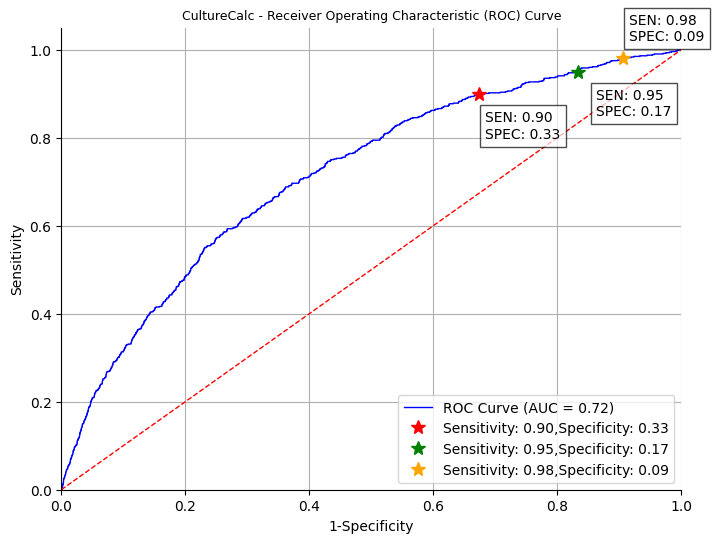

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve points
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_test, y_pred_prob_l2)

# Calculate the AUC for the ROC curve
roc_auc_l2 = auc(fpr_l2, tpr_l2)


# Find the index where TPR is closest to 0.9
target_tpr = 0.9
index = np.argmin(np.abs(tpr_l2 - target_tpr))

# Get the corresponding threshold, FPR, and TPR
optimal_threshold = thresholds_l2[index]
optimal_tpr = tpr_l2[index]
optimal_fpr = fpr_l2[index]
sensitivity = optimal_tpr
specificity = 1-optimal_fpr



# Find the index where TPR is closest to 0.95
target_tpr2 = 0.95
index2 = np.where(tpr_l2>=target_tpr2)[0][0]
optimal_threshold2 = thresholds_l2[index2]
optimal_tpr2 = tpr_l2[index2]
optimal_fpr2 = fpr_l2[index2]
sensitivity2 = optimal_tpr2
specificity2 = 1-optimal_fpr2


# Find the index where TPR is closest to 0.98
target_tpr3 = 0.98
index3 = np.where(tpr_l2>=target_tpr3)[0][0]
optimal_threshold3 = thresholds_l2[index3]
optimal_tpr3 = tpr_l2[index3]
optimal_fpr3 = fpr_l2[index3]
sensitivity3 = optimal_tpr3
specificity3 = 1-optimal_fpr3


# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_l2, tpr_l2, color='blue', lw=1, label=f'ROC Curve (AUC = {roc_auc_l2:.2f})')


# Plot the asterisk at TPR = 0.9
label=f'Sensitivity: {sensitivity:.2f},Specificity: {specificity:.2f}'
plt.plot(optimal_fpr, optimal_tpr, 'r*', markersize=10, label=label)

# Plot the asterisk at TPR = 0.95
label=f'Sensitivity: {sensitivity2:.2f},Specificity: {specificity2:.2f}'
plt.plot(optimal_fpr2, optimal_tpr2, 'g*', markersize=10, label=label)

# Plot the asterisk at TPR = 0.95
label=f'Sensitivity: {sensitivity3:.2f},Specificity: {specificity3:.2f}'
plt.plot(optimal_fpr3, optimal_tpr3, '*',color='orange', markersize=10, label=label)

# Annotate the sensitivity, specificity, etc.
plt.text(optimal_fpr + 0.01, optimal_tpr - 0.1, 
         f'SEN: {sensitivity:.2f}\nSPEC: {specificity:.2f}', 
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))



# Annotate the sensitivity, specificity, etc.
plt.text(optimal_fpr2 + 0.03, optimal_tpr2 - 0.1, 
         f'SEN: {sensitivity2:.2f}\nSPEC: {specificity2:.2f}', 
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))


# Annotate the sensitivity, specificity, etc.
plt.text(optimal_fpr3 + 0.01, optimal_tpr2 + 0.07, 
         f'SEN: {sensitivity3:.2f}\nSPEC: {specificity3:.2f}', 
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))



# Plotting the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('CultureCalc - Receiver Operating Characteristic (ROC) Curve',fontsize=9)
plt.legend(loc='lower right')
plt.grid(True)
# Show the plot
# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('performance.png')
# Show the plot
plt.show()

## pointing system

In [32]:
coefficients = model_l2.coef_[0] 
# Get the feature names from your training data (assuming X_train2 is a DataFrame)
feature_names = X_train2.columns

# Identify non-zero coefficients and get corresponding feature names
non_zero_indices = np.where(coefficients != 0)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]

ROC-AUC for the Point System: 0.7204


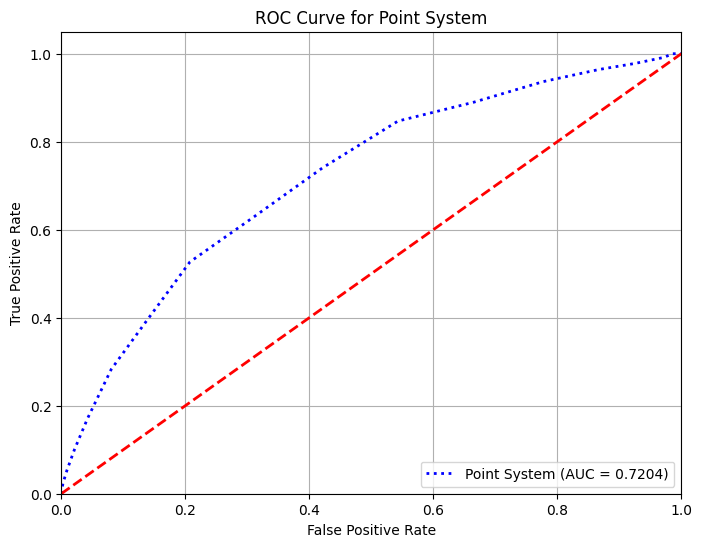

In [33]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Step 1: Create the Point System

# Define the scaling factor
scaling_factor = 100


# Step 2: Apply the Point System to the Data
medians = X_train_im2[non_zero_features].quantile(0.5)
Q25 = X_train_im2[non_zero_features].quantile(0.25)
Q75 = X_train_im2[non_zero_features].quantile(0.75)


def calculate_points(row, medians,Q25,Q75, coefficients,scaling_factor=10):
    points = 0
    
    for feature, coef in zip(non_zero_features, coefficients):
        if 'min' in feature and coef>0:
            if  row[feature]>medians[feature]:
                points += round(coef*scaling_factor)
        elif 'min' in feature and coef<0:
            if  row[feature]<medians[feature]:
                points +=round( -1*coef*scaling_factor)
        elif 'max' in  feature and coef>0:
            if  row[feature]>medians[feature]:
                points +=round(coef*scaling_factor)
        elif 'max' in  feature and coef<0:
            if  row[feature]<medians[feature]:
                points +=round( -1*coef*scaling_factor)
        else:
            if row[feature] > medians[feature]:
                    points += round(coef*scaling_factor)  # Add points if feature value is above the median
        #else:
            #if row[feature] < medians[feature]:
                #points = -1 * coef*scaling_factor  # Subtract points if feature value is below the median
    return points


# Apply this function to each row in the test set (use the original feature values)
total_points = X_test.apply(calculate_points, axis=1, args=(medians,Q25,Q75,non_zero_coefficients))

# Calculate the ROC-AUC for the point system
roc_auc_points = roc_auc_score(y_test, total_points)
print(f"ROC-AUC for the Point System: {roc_auc_points:.4f}")

# Optional: Plot the ROC curve
fpr_points, tpr_points, _ = roc_curve(y_test, total_points)
plt.figure(figsize=(8, 6))
plt.plot(fpr_points, tpr_points, color='blue',linestyle='dotted', lw=2, label=f'Point System (AUC = {roc_auc_points:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Point System')
plt.legend(loc='lower right')
plt.show()

In [34]:
fpr_points, tpr_points, threshold_points = roc_curve(y_test, total_points)
threshold_points[np.where(tpr_points>=0.98)[0][0]]

2.0

In [35]:
import pandas as pd

def generate_feature_points_table(non_zero_features, coefficients, medians, scaling_factor=10):
    # Create a list to store the rows for the table
    table_data = []

    for feature, coef in zip(non_zero_features, coefficients):
        if 'min' in feature and coef>0:
                row = {
                'Feature': feature,
                'Condition': f'> {round(medians[feature],3)}',
                'Points': round(coef*scaling_factor)
                    }
        elif 'min' in feature and coef<0:
                row = {
                'Feature': feature,
                'Condition': f'< {round(medians[feature],3)}',
                'Points': round(-1*coef*scaling_factor)
                    }
        elif 'max' in  feature and coef>0:
                row = {
                'Feature': feature,
                'Condition': f'> {round(medians[feature],3)}',
                'Points': round(coef*scaling_factor)
                    }
        elif 'max' in  feature and coef<0:
                row = {
                'Feature': feature,
                'Condition': f'< {round(medians[feature],3)}',
                'Points': round(-1*coef*scaling_factor)
                    }
        else:
                row = {
                'Feature': feature,
                'Condition': f'> {round(medians[feature],3)}',
                'Points': round(coef*scaling_factor)
                    }
        # Add the row to the table data
        table_data.append(row)
    
    # Convert the list of rows into a DataFrame
    df_points_table = pd.DataFrame(table_data)
    return df_points_table

# Example usage
df_points_table = generate_feature_points_table(non_zero_features, coefficients, medians, scaling_factor=10)

# Display the table
print(df_points_table)

def save_table_as_image(df, filename="feature_points_table.png"):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(len(df.columns) * 2, len(df) * 0.4))  # Adjust size based on table content
    ax.axis('tight')
    ax.axis('off')

    # Create the table plot
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # Adjust font size
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    
    # Adjust column width
    table.scale(1, 1.5)

    # Save the table as an image
    #plt.show()
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close(fig)  # Close the figure after saving to prevent display

# Example usage
save_table_as_image(df_points_table[df_points_table.Points>0], "feature_points_table.png")


          Feature Condition  Points
0   max_heartrate   > 100.0       2
1    max_resprate    > 20.0       0
2           Fever     > 0.0       3
3       min_sysbp   < 113.0       2
4         max_wbc     > 9.9       2
5          min_na   < 136.0       1
6        min_hco3    < 24.0       1
7         min_plt   < 222.0       2
8          max_cr    > 0.96       1
9     max_lactate    > 1.43       1
10         gender     > 0.0       0
11            age    > 65.0       2


In [36]:
# Calculate sensitivity, specificity, PPV, and NPV
y_pred_optimal3 = (total_points >=6).astype(int)
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, y_pred_optimal3).ravel()
sensitivity3 = tp3 / (tp3 + fn3)  # Sensitivity or Recall
specificity3 = tn3 / (tn3 + fp3)  # Specificity
ppv3 = tp3 / (tp3 + fp3)          # Positive Predictive Value (Precision)
npv3 = tn3 / (tn3 + fn3)          # Negative Predictive Value
print(sensitivity3)
print(specificity3)
print(ppv3)
print(npv3)


0.8896551724137931
0.33506472426246803
0.03787211555398978
0.9904042221422574


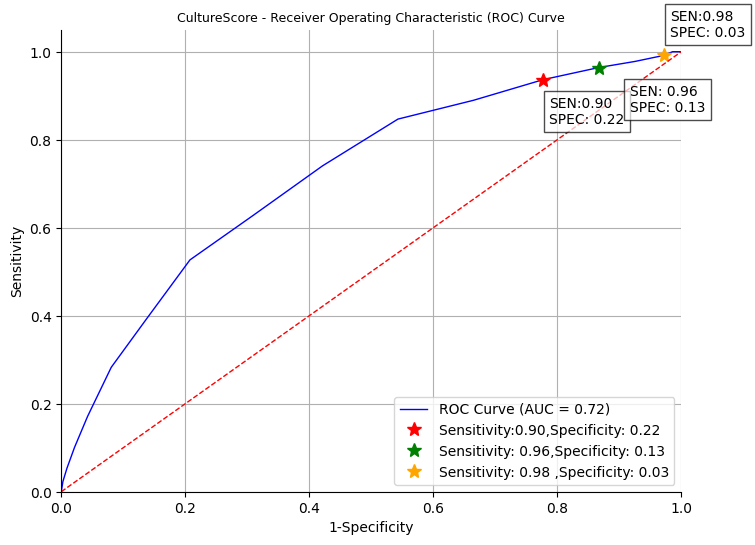

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Assuming you already have your model predictions and true labels
# y_test: true labels
# y_pred_prob: predicted probabilities

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, total_points)


# Find the index where TPR is closest to 0.9
target_tpr = 0.90
index =  np.where(tpr>=target_tpr)[0][0]

# Get the corresponding threshold, FPR, and TPR
optimal_threshold = thresholds[index]
optimal_tpr = tpr[index]
optimal_fpr = fpr[index]

# Calculate sensitivity, specificity, PPV, and NPV
y_pred_optimal = (total_points >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()
sensitivity = tp / (tp + fn)  # Sensitivity or Recall
specificity = tn / (tn + fp)  # Specificity
ppv = tp / (tp + fp)          # Positive Predictive Value (Precision)
npv = tn / (tn + fn)          # Negative Predictive Value



# Find the index where TPR is closest to 0.95
target_tpr2 = 0.95
index2 = np.where(tpr>=target_tpr2)[0][0]
optimal_threshold2 = thresholds[index2]
optimal_tpr2 = tpr[index2]
optimal_fpr2 = fpr[index2]

# Calculate sensitivity, specificity, PPV, and NPV
y_pred_optimal2 = (total_points >= optimal_threshold2).astype(int)
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, y_pred_optimal2).ravel()
sensitivity2 = tp2 / (tp2 + fn2)  # Sensitivity or Recall
specificity2 = tn2 / (tn2 + fp2)  # Specificity
ppv2 = tp2 / (tp2 + fp2)          # Positive Predictive Value (Precision)
npv2 = tn2 / (tn2 + fn2)          # Negative Predictive Value




# Find the index where TPR is closest to 0.98
target_tpr3 = 0.98
index3 = np.where(tpr>=target_tpr3)[0][0]
optimal_threshold3 = thresholds[index3]
optimal_tpr3 = tpr[index3]
optimal_fpr3 = fpr[index3]

# Calculate sensitivity, specificity, PPV, and NPV
y_pred_optimal3 = (total_points >= optimal_threshold3).astype(int)
tn3, fp3, fn3, tp3 = confusion_matrix(y_test, y_pred_optimal3).ravel()
sensitivity3 = tp3 / (tp3 + fn3)  # Sensitivity or Recall
specificity3 = tn3 / (tn3 + fp3)  # Specificity
ppv3 = tp3 / (tp3 + fp3)          # Positive Predictive Value (Precision)
npv3 = tn3 / (tn3 + fn3)          # Negative Predictive Value



# Plot the ROC curve
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', lw=1, label=f'ROC Curve (AUC = {roc_auc_score(y_test, total_points):.2f})')

# Plot the asterisk at TPR = 0.9
label=f'Sensitivity:0.90,Specificity: {specificity:.2f}'
plt.plot(optimal_fpr, optimal_tpr, 'r*', markersize=10, label=label)

# Plot the asterisk at TPR = 0.95
label=f'Sensitivity: {sensitivity2:.2f},Specificity: {specificity2:.2f}'
plt.plot(optimal_fpr2, optimal_tpr2, 'g*', markersize=10, label=label)

# Plot the asterisk at TPR = 0.95
label=f'Sensitivity: 0.98 ,Specificity: {specificity3:.2f}'
plt.plot(optimal_fpr3, optimal_tpr3, '*',color='orange', markersize=10, label=label)

# Annotate the sensitivity, specificity, etc.
plt.text(optimal_fpr + 0.01, optimal_tpr - 0.1, 
         f'SEN:0.90\nSPEC: {specificity:.2f}', 
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))



# Annotate the sensitivity, specificity, etc.
plt.text(optimal_fpr2 + 0.05, optimal_tpr2 - 0.1, 
         f'SEN: {sensitivity2:.2f}\nSPEC: {specificity2:.2f}', 
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))


# Annotate the sensitivity, specificity, etc.
plt.text(optimal_fpr3 + 0.01, optimal_tpr2 + 0.07, 
         f'SEN:0.98\nSPEC: {specificity3:.2f}', 
         fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.7))

# Plot the diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('CultureScore - Receiver Operating Characteristic (ROC) Curve',fontsize=9)
plt.legend(loc='lower right')
plt.grid(True)
# Show the plot
# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('point_base.png')
plt.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calculate the ROC curve points
fpr_l2, tpr_l2, thresholds_roc = roc_curve(y_test, y_pred_prob_l2)

# Calculate the AUC for the ROC curve
roc_auc_l2 = auc(fpr_l2, tpr_l2)

# Initialize lists to store NPV and Specificity
specificities = []
npvs = []

# Loop through ROC thresholds to calculate Specificity and NPV
for threshold in thresholds_roc:
    # Get the binary predictions at this threshold
    y_pred = (y_pred_prob_l2 >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Calculate Specificity and NPV
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Append to lists
    specificities.append(specificity)
    npvs.append(npv)



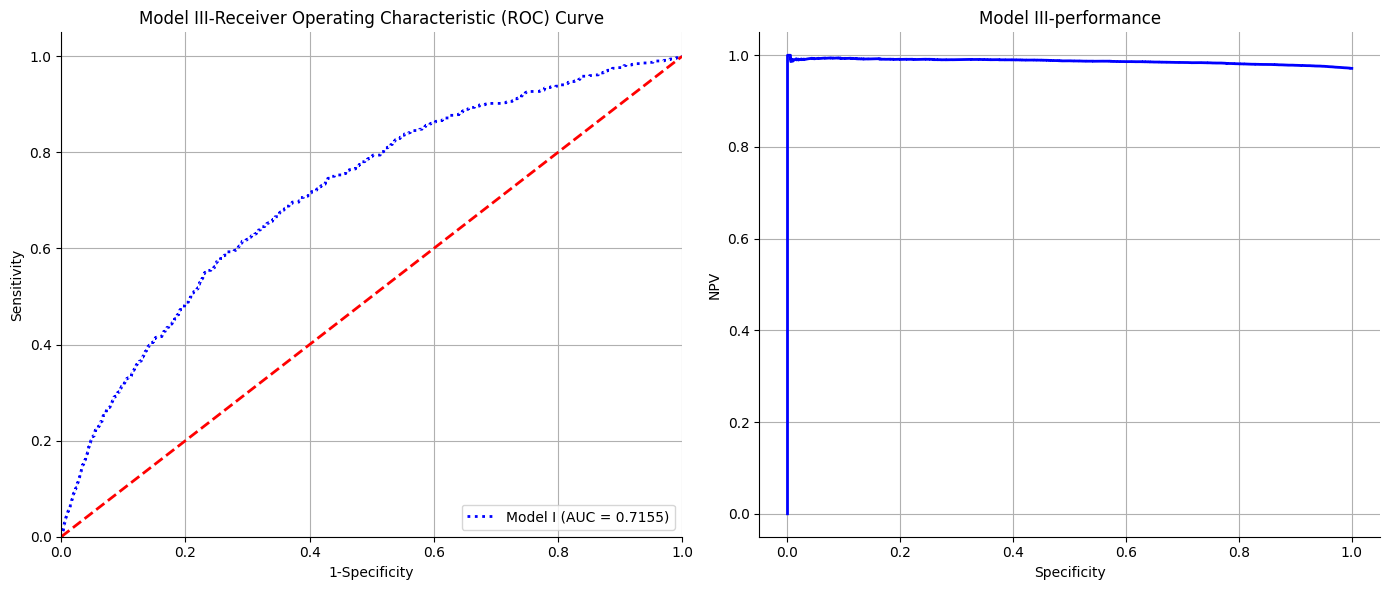

In [39]:
# Create a figure with two subplots: one for ROC and one for NPV vs Specificity
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC curve on the first subplot
ax[0].plot(fpr_l2, tpr_l2, color='blue', lw=2, linestyle='dotted', label=f'Model I (AUC = {roc_auc_l2:.4f})')
ax[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('1-Specificity')
ax[0].set_ylabel('Sensitivity')
ax[0].set_title('Model III-Receiver Operating Characteristic (ROC) Curve')
ax[0].legend(loc='lower right')
ax[0].grid(True)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)


# Plot NPV vs Specificity on the second subplot
ax[1].plot(specificities, npvs, color='blue', lw=2)
ax[1].set_xlabel('Specificity')
ax[1].set_ylabel('NPV')
ax[1].set_title('Model III-performance')
ax[1].grid(True)


ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
# Adjust layout and show the plots
plt.tight_layout()
plt.savefig('performance.png')
plt.show()

In [40]:
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_l2)

# Find the threshold where sensitivity (TPR) >= 0.9
threshold_index = np.argmax(tpr >= 0.95)
optimal_threshold = thresholds[threshold_index]

# Use the optimal threshold to make binary predictions
y_pred_optimal = (y_pred_prob_l2 >= optimal_threshold).astype(int)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

# Calculate sensitivity, specificity, PPV, and NPV
sensitivity = tp / (tp + fn)  # Sensitivity or Recall
specificity = tn / (tn + fp)  # Specificity
ppv = tp / (tp + fp)          # Positive Predictive Value (Precision)
npv = tn / (tn + fn)          # Negative Predictive Value

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"PPV (Precision): {ppv:.4f}")
print(f"NPV: {npv:.4f}")

Optimal Threshold: 0.2960
Sensitivity: 0.9503
Specificity: 0.1668
PPV (Precision): 0.0325
NPV: 0.9913


In [75]:
import numpy as np
import pickle
from sklearn.metrics import roc_curve

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_l2)

# Save the ROC data to a file
roc_data = {
    'fpr': fpr[1:],
    'tpr': tpr[1:],
    'thresholds': thresholds[1:],
}

with open('roc_data.pkl', 'wb') as f:
    pickle.dump(roc_data, f)

# XGBOOST

In [41]:
# Assuming Train_set_df and Test_set_df are your training and testing data frames respectively
# Prepare the training data
X_train = Train_set_df.drop(columns=['positive_blood_culture', 'positive_blood_culture_in_week','anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
y_train = Train_set_df['positive_blood_culture']

# Prepare the test data
X_test = Test_set_df.drop(columns=['positive_blood_culture', 'positive_blood_culture_in_week','anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
y_test = Test_set_df['positive_blood_culture']


X_val = Val_set_df.drop(columns=['positive_blood_culture', 'positive_blood_culture_in_week','anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded'])
y_val = Val_set_df['positive_blood_culture']


In [43]:
X_train = X_train.drop(columns=['datapoint'])
X_test = X_test.drop(columns=['datapoint'])
X_val = X_val.drop(columns=['datapoint'])

In [44]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

In [45]:
# Calculate the ratio of negative to positive samples
scale_pos_weight = (len(y_train[y_train == 0]) / len(y_train[y_train == 1]))#*2

params = {
    'max_depth':4,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': scale_pos_weight  # Add this line
}
num_rounds = 30

In [46]:
bst = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'val')])

[0]	val-auc:0.74233
[1]	val-auc:0.75264
[2]	val-auc:0.75799
[3]	val-auc:0.76569
[4]	val-auc:0.77579
[5]	val-auc:0.77920
[6]	val-auc:0.78424
[7]	val-auc:0.78908
[8]	val-auc:0.79021
[9]	val-auc:0.79386
[10]	val-auc:0.79482
[11]	val-auc:0.79649
[12]	val-auc:0.79611
[13]	val-auc:0.79620
[14]	val-auc:0.79632
[15]	val-auc:0.79635
[16]	val-auc:0.79732
[17]	val-auc:0.79962
[18]	val-auc:0.80078
[19]	val-auc:0.80152
[20]	val-auc:0.80038
[21]	val-auc:0.80041
[22]	val-auc:0.79985
[23]	val-auc:0.80026
[24]	val-auc:0.79892
[25]	val-auc:0.79893
[26]	val-auc:0.79917
[27]	val-auc:0.79692
[28]	val-auc:0.79659
[29]	val-auc:0.79593


In [47]:
y_pred = bst.predict(dtest)
y_pred_binary = (y_pred > 0.5).astype(int)  # converting probabilities to binary output
y_pred_val = bst.predict(dval)

In [48]:
from sklearn.metrics import accuracy_score, roc_auc_score
auc_score = roc_auc_score(y_test, y_pred)
print(f'AUC Score: {auc_score:.2f}')

AUC Score: 0.80


In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

In [50]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)  # Calculate area under the curve

fpr_val, tpr_val,_ = roc_curve(y_val, y_pred_val)
roc_auc_tr = auc(fpr_val, tpr_val)

In [51]:
index=np.where(tpr>=0.9)[0][0]
print('sensitivity',tpr[index])
print('specifity',1-fpr[index])
print('Threshod',thresholds[index])
y_pred_binary = (y_pred > 0.3).astype(int) 

sensitivity 0.9006896551724138
specifity 0.5010753560848923
Threshod 0.30114764


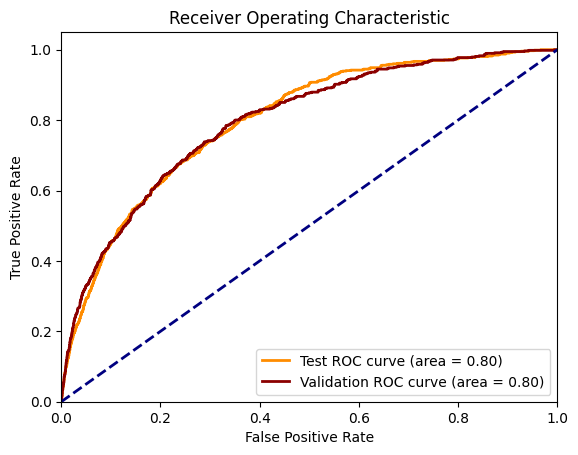

In [52]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Test ROC curve (area = {roc_auc:.2f})')
plt.plot(fpr_val, tpr_val, color='darkred', lw=2, label=f'Validation ROC curve (area = {roc_auc_tr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()

In [53]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_val)
average_precision_val = average_precision_score(y_val, y_pred_val)


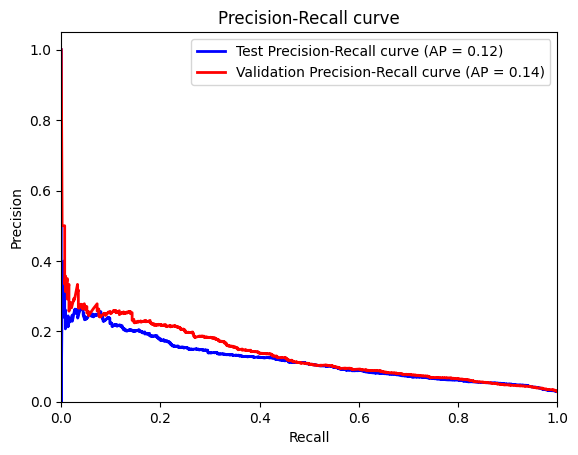

In [54]:
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'Test Precision-Recall curve (AP = {average_precision:.2f})')
plt.plot(recall_val, precision_val, color='red', lw=2, label=f'Validation Precision-Recall curve (AP = {average_precision_val:.2f})')

#plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.savefig('auc_pr.png')
plt.show()

In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

In [57]:
recall_val = recall_score(y_test, y_pred_binary)

ppv_val = precision_score(y_test, y_pred_binary)
npv_val = tn / (tn + fn)
specificity_val = tn / (tn + fp)

In [58]:
print(f"Recall (Sensitivity): {recall_val:.2f}")
print(f"specificity: {specificity_val:.2f}")
print(f"Precision (PPV): {ppv_val:.2f}")
print(f"Negative Predictive Value (NPV): {npv_val:.2f}")


Recall (Sensitivity): 0.91
specificity: 0.50
Precision (PPV): 0.05
Negative Predictive Value (NPV): 0.99


In [75]:
#!pip install shap

In [60]:
import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
plt.figure()
#shap.initjs()
#shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# Summary plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig('shap_summary_plot.png', bbox_inches='tight')
plt.close()

In [61]:
# SHOW THE SHAP VALUES for specific features interesting for Clinicians 

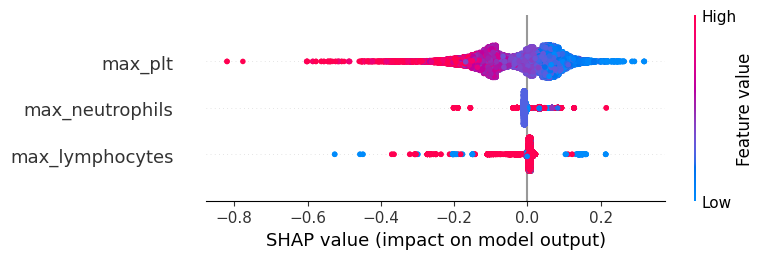

In [62]:

selected_features = ['max_lymphocytes', 'max_neutrophils', 'max_plt']  # Replace with actual feature names
X_test_subset = X_test[selected_features]

# Handle missing values in X_test before generating dependence plot
X_test_clean = X_test_subset.fillna(X_test.mean())  # You can also use other methods to handle missing values


shap_values_subset = shap_values[:, [X_train.columns.get_loc(feat) for feat in selected_features]]

# Summary plot for selected features
shap.summary_plot(shap_values_subset, X_test_clean)

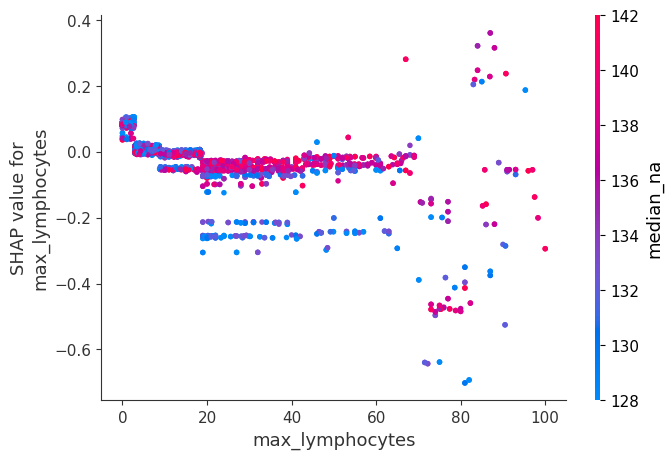

In [31]:
# Calculate SHAP values using TreeExplainer
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# Handle missing values in X_test before generating dependence plot
X_test_clean = X_test.fillna(X_test.mean())  # You can also use other methods to handle missing values

# Dependence plot
shap.dependence_plot("max_lymphocytes", shap_values, X_test_clean)  # Replace "median_wbc" with an actual feature name
